# Multiple conformations

This notebook explores the impact of including multiple conformations into the cross-docking experiment with **Posit**.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
posit_conformation_results = pd.read_csv("../data/posit_conformation_results.csv", index_col=0)
docking_benchmark_dataset = pd.read_csv("../data/docking_benchmark_dataset.csv", index_col=0)
pocket_rmsd_matrix = pd.read_csv("../data/pocket_rmsd_matrix.csv", index_col=0)

In [5]:
# apply conformation to results
conformation_benchmark_groups = {
    259: [  # KLIFS kinase ID
        ["in", "in"],  # DFG, aC helix conformation
        ["out-like", "in"]
    ],
    509: [
        ["out", "in"],
        ["in", "out"]
    ]
}
posit_conformation_results.loc[:, "protein_conformation"] = "None"
posit_conformation_results.loc[:, "ligand_conformation"] = "None"
for kinase_id, conformations in conformation_benchmark_groups.items():
    for (dfg, ac_helix) in conformations:
        pdb_id_selection = docking_benchmark_dataset[
            (docking_benchmark_dataset["kinase.klifs_id"] == kinase_id) &
            (docking_benchmark_dataset["structure.dfg"] == dfg) &
            (docking_benchmark_dataset["structure.ac_helix"] == ac_helix)
        ]["structure.pdb_id"].to_list()
        protein_indices = posit_conformation_results[posit_conformation_results["protein_pdb_id"].isin(pdb_id_selection)].index
        ligand_indices = posit_conformation_results[posit_conformation_results["ligand_pdb_id"].isin(pdb_id_selection)].index
        posit_conformation_results.loc[protein_indices, "protein_conformation"] = f"{dfg}/{ac_helix}"
        posit_conformation_results.loc[ligand_indices, "ligand_conformation"] = f"{dfg}/{ac_helix}"

In [6]:
def get_pocket_rmsd(pdb_id1, pdb_id2, docking_benchmark_dataset=docking_benchmark_dataset, pocket_rmsd_matrix=pocket_rmsd_matrix):
    """Retrieve the KLIFS pocket RMSD from two kinase structures."""
    structure_klifs_id1 = docking_benchmark_dataset[
        docking_benchmark_dataset["structure.pdb_id"] == pdb_id1
    ]["structure.klifs_id"].iloc[0]
    structure_klifs_id2 = docking_benchmark_dataset[
        docking_benchmark_dataset["structure.pdb_id"] == pdb_id2
    ]["structure.klifs_id"].iloc[0] 
    pocket_rmsd = pocket_rmsd_matrix[str(structure_klifs_id1)][structure_klifs_id2]
    return pocket_rmsd

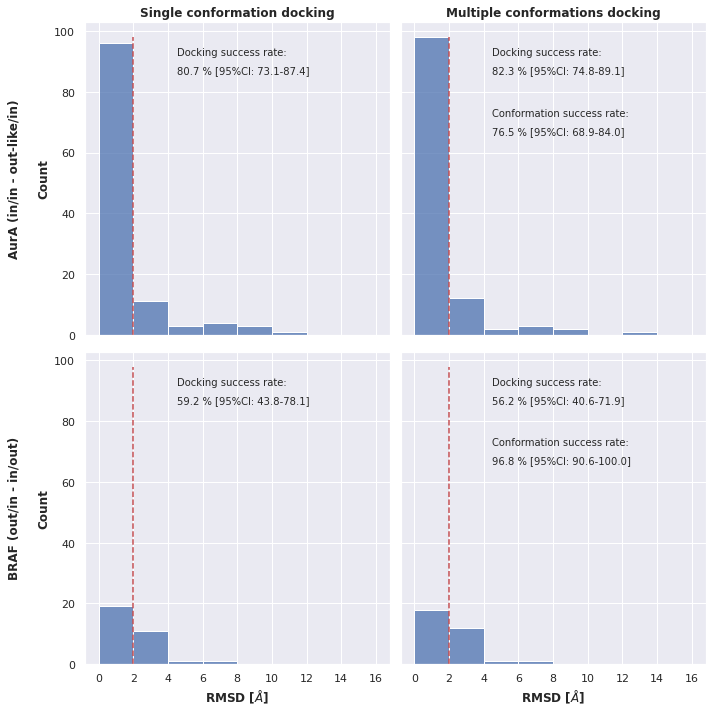

In [7]:
def plot_performance(posit_conformation_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # kinase conformation groups
    kinase_conformation_groups = {
        "AurA": [  # kinase name
            "in/in",  # DFG, aC helix conformation
            "out-like/in"
        ],
        "BRAF": [
            "out/in",
            "in/out"
        ]
    }
    
    # 4 subplots
    fig, axes = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 10))
    bins = range(0, int(posit_conformation_results["rmsd"].max()), 2)
    
    # plot results and sample success rates for each kinase and conformation
    sampled_success_rates_pose = []
    sampled_success_rates_conformation = []
    for i, (kinase_name, conformations) in enumerate(kinase_conformation_groups.items()):
        for j, focus in enumerate(["Single conformation docking", "Multiple conformations docking"]):
            result_selection = posit_conformation_results[posit_conformation_results.index.str.contains(kinase_name)]
            if focus == "Single conformation docking":
                result_selection = result_selection[
                    result_selection["protein_conformation"] == result_selection["ligand_conformation"]
                ]
            result_selection = result_selection.sort_values("docking_score")
            result_selection = result_selection.sort_values("posit_probability", ascending=False)
            result_selection = result_selection.groupby(["ligand_pdb_id"]).head(1)
            
            # plot histogram
            sns.histplot(data=result_selection, x="rmsd", bins=bins, ax=axes[i][j])
            axes[i][0].set_ylabel(f"{kinase_name} ({conformations[0]} - {conformations[1]})\n\nCount", fontweight="bold")
            axes[0][j].set_title(focus, fontweight="bold")
            axes[1][j].set_xlabel("RMSD [$\AA$]", fontweight="bold")
            axes[i][j].vlines(2, ymin=0, ymax=98, colors="r", linestyles="dashed")
            
            # sample docking success rates and add to plot
            success_labels = (result_selection["rmsd"] <= 2).to_list()
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_success_labels = resample(success_labels, replace=True)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates_pose.append([
                kinase_name,
                conformations,
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            axes[i][j].annotate(
                "Docking success rate:", 
                xy=(4.5, 92),
                fontsize=10,
            )
            axes[i][j].annotate(
                f"{success_rate_mean:.1f} % [95%CI: {ci_lower_bound:.1f}-{ci_upper_bound:.1f}]", 
                xy=(4.5, 86),
                fontsize=10,
            )
            
            # sample conformation selection success rate and add to plot
            if focus == "Multiple conformations docking":
                success_labels = (result_selection["protein_conformation"] == result_selection["ligand_conformation"]).to_list()
                sampled_success_rates_i = []
                for _ in range(n_bootstrap):
                    sampled_success_labels = resample(success_labels, replace=True)
                    sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
                sampled_success_rates_i = sorted(sampled_success_rates_i)
                cutoff = (1 - ci) / 2
                success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
                ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
                ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
                sampled_success_rates_conformation.append([
                    kinase_name,
                    conformations,
                    focus,
                    success_rate_mean,
                    ci_lower_bound,
                    ci_upper_bound
                ])
                axes[i][j].annotate(
                    "Conformation success rate:", 
                    xy=(4.5, 72),
                    fontsize=10,
                )
                axes[i][j].annotate(
                    f"{success_rate_mean:.1f} % [95%CI: {ci_lower_bound:.1f}-{ci_upper_bound:.1f}]", 
                    xy=(4.5, 66),
                    fontsize=10,
                )
                
    sampled_success_rates_pose = pd.DataFrame(
        sampled_success_rates_pose, 
        columns=["kinase", "conformations", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    sampled_success_rates_conformation = pd.DataFrame(
        sampled_success_rates_conformation, 
        columns=["kinase", "conformations", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
            
    plt.tight_layout()
    
    return sampled_success_rates_pose, sampled_success_rates_conformation

sampled_success_rates_pose, sampled_success_rates_conformation = plot_performance(posit_conformation_results)

In [8]:
posit_conformation_results["pocket_rmsd"] = posit_conformation_results.apply(lambda row: get_pocket_rmsd(row["protein_pdb_id"], row["ligand_pdb_id"]), axis=1)

In [9]:
aura = posit_conformation_results[posit_conformation_results.index.str.contains("AurA")]
aura_within_conformation = []
for i, row in aura.iterrows():
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "in":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "in":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    aura_within_conformation.append(row)
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "out-like":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "out-like":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    aura_within_conformation.append(row)
aura_within_conformation = pd.DataFrame(aura_within_conformation, columns=aura.columns)
aura_across_conformation = []
for i, row in aura.iterrows():
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "in":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "out-like":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    aura_across_conformation.append(row)
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "out-like":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "in":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    aura_across_conformation.append(row)
aura_across_conformation = pd.DataFrame(aura_across_conformation, columns=aura.columns)
braf = posit_conformation_results[posit_conformation_results.index.str.contains("BRAF")]
braf_within_conformation = []
for i, row in braf.iterrows():
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "in":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "out":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "in":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "out":
                    braf_within_conformation.append(row)
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "out":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "out":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    braf_within_conformation.append(row)
braf_within_conformation = pd.DataFrame(braf_within_conformation, columns=braf.columns)
braf_across_conformation = []
for i, row in braf.iterrows():
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "in":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "out":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "out":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
                    braf_across_conformation.append(row)
    if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.dfg"] == "out":
        if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["ligand_pdb_id"]].iloc[0]["structure.ac_helix"] == "in":
            if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.dfg"] == "in":
                if docking_benchmark_dataset[docking_benchmark_dataset["structure.pdb_id"] == row["protein_pdb_id"]].iloc[0]["structure.ac_helix"] == "out":
                    braf_across_conformation.append(row)
braf_across_conformation = pd.DataFrame(braf_across_conformation, columns=braf.columns)

In [10]:
conformation_rmsds = []
for name, subset in zip(["AurA\nsame", "AurA\ndifferent", "BRAF\nsame", "BRAF\ndifferent"], [aura_within_conformation, aura_across_conformation, braf_within_conformation, braf_across_conformation]):
    for rmsd in subset.pocket_rmsd:
        conformation_rmsds.append([name, rmsd])
conformation_rmsds = pd.DataFrame(conformation_rmsds, columns=["subset", "pocket_rmsd"])

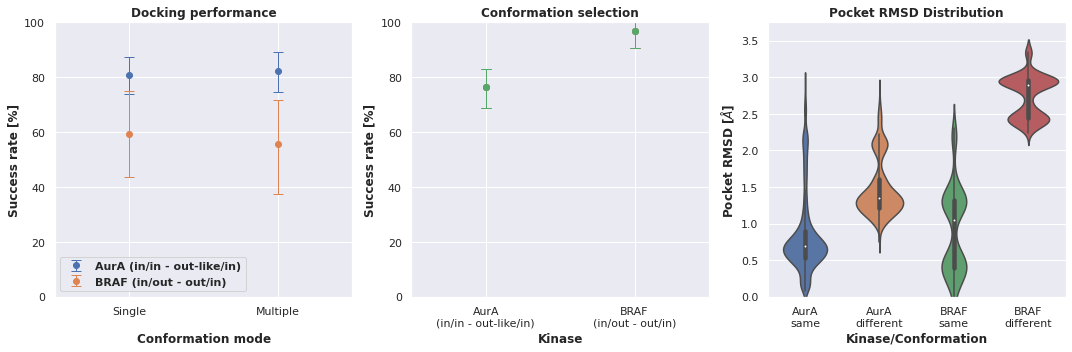

In [11]:
def plot_performance(posit_conformation_results, conformation_rmsds, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # kinase conformation groups
    kinase_conformation_groups = {
        "AurA": [  # kinase name
            "in/in",  # DFG, aC helix conformation
            "out-like/in"
        ],
        "BRAF": [
            "out/in",
            "in/out"
        ]
    }
    
    # 2 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # sample success rates for each kinase and conformation
    sampled_success_rates_pose = []
    sampled_success_rates_conformation = []
    for i, (kinase_name, conformations) in enumerate(kinase_conformation_groups.items()):
        for j, focus in enumerate(["Single", "Multiple"]):
            result_selection = posit_conformation_results[posit_conformation_results.index.str.contains(kinase_name)]
            if focus == "Single":
                result_selection = result_selection[
                    result_selection["protein_conformation"] == result_selection["ligand_conformation"]
                ]
            result_selection = result_selection.sort_values("docking_score")
            result_selection = result_selection.sort_values("posit_probability", ascending=False)
            result_selection = result_selection.groupby(["ligand_pdb_id"]).head(1)
            
            # sample docking success rates
            success_labels = (result_selection["rmsd"] <= 2).to_list()
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_success_labels = resample(success_labels, replace=True)
                sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            cutoff = (1 - ci) / 2
            success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
            ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
            sampled_success_rates_pose.append([
                kinase_name,
                conformations,
                "docking pose",
                focus,
                success_rate_mean,
                ci_lower_bound,
                ci_upper_bound
            ])
            
            # sample conformation selection success rate
            if focus == "Multiple":
                success_labels = (result_selection["protein_conformation"] == result_selection["ligand_conformation"]).to_list()
                sampled_success_rates_i = []
                for _ in range(n_bootstrap):
                    sampled_success_labels = resample(success_labels, replace=True)
                    sampled_success_rates_i.append((sum(sampled_success_labels) / len(sampled_success_labels)) * 100)
                sampled_success_rates_i = sorted(sampled_success_rates_i)
                cutoff = (1 - ci) / 2
                success_rate_mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
                ci_lower_bound = sampled_success_rates_i[int(n_bootstrap * cutoff)]
                ci_upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + cutoff))]
                sampled_success_rates_conformation.append([
                    kinase_name,
                    conformations,
                    "conformation selection",
                    focus,
                    success_rate_mean,
                    ci_lower_bound,
                    ci_upper_bound
                ])
                
    sampled_success_rates_pose = pd.DataFrame(
        sampled_success_rates_pose, 
        columns=["kinase", "conformations", "success_type", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    sampled_success_rates_conformation = pd.DataFrame(
        sampled_success_rates_conformation, 
        columns=["kinase", "conformations", "success_type", "focus", "success_rate", "ci_lower", "ci_upper"]
    )
    sampled_success_rates = pd.concat([sampled_success_rates_pose, sampled_success_rates_conformation])
    
    # plot docking pose results
    sampled_success_rates_docking = sampled_success_rates[sampled_success_rates["success_type"] == "docking pose"]
    for label, kinase in zip(["AurA (in/in - out-like/in)", "BRAF (in/out - out/in)"], ["AurA", "BRAF"]):
        sampled_success_rates_docking_i = sampled_success_rates_docking[sampled_success_rates_docking["kinase"] == kinase]
        axes[0].errorbar(
            x=sampled_success_rates_docking_i["focus"],
            y=sampled_success_rates_docking_i["success_rate"],
            yerr=[
                sampled_success_rates_docking_i["success_rate"] - sampled_success_rates_docking_i["ci_lower"], 
                sampled_success_rates_docking_i["ci_upper"] - sampled_success_rates_docking_i["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1,
            label=label
        )
    axes[0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[0].set_ylim([0, 100])
    axes[0].set_xlabel("Conformation mode", fontweight="bold")
    axes[0].set_xticks(ticks=[-0.5, 0, 1, 1.5], labels=["", "Single\n", "Multiple\n", ""])
    axes[0].set_title("Docking performance", fontweight="bold")
    axes[0].legend(prop=dict(weight="bold"), fancybox=True)
    
    # plot conformation selection results
    sampled_success_rates_conformation = sampled_success_rates[sampled_success_rates["success_type"] == "conformation selection"]
    for i in range(3):  # get third color
        axes[1].errorbar(
            x=sampled_success_rates_conformation["kinase"],
            y=sampled_success_rates_conformation["success_rate"],
            yerr=[
                sampled_success_rates_conformation["success_rate"] - sampled_success_rates_conformation["ci_lower"], 
                sampled_success_rates_conformation["ci_upper"] - sampled_success_rates_conformation["success_rate"]
            ],
            fmt="o",
            elinewidth=1,
            capsize=5,
            capthick=1,
            label=focus
        )
    axes[1].set_ylabel("Success rate [%]", fontweight="bold")
    axes[1].set_xticks(ticks=[-0.5, 0, 1, 1.5], labels=["", "AurA\n(in/in - out-like/in)", "BRAF\n(in/out - out/in)", ""])
    axes[1].set_xlabel("Kinase", fontweight="bold")
    axes[1].set_ylim([0, 100])
    axes[1].set_title("Conformation selection", fontweight="bold")
    
    # plot rmsd of conformation subsets
    sns.violinplot(x="subset", y="pocket_rmsd", data=conformation_rmsds, ax=axes[2])
    axes[2].set_xlabel("Kinase/Conformation", fontweight="bold")
    axes[2].set_ylabel("Pocket RMSD [$\AA$]", fontweight="bold")
    axes[2].set_ylim([0, 3.75])
    axes[2].set_title("Pocket RMSD Distribution", fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(directory / "multiple_conformations.pdf", dpi=300)
    
    return sampled_success_rates

sampled_success_rates = plot_performance(posit_conformation_results, conformation_rmsds)

In [12]:
sampled_success_rates

,kinase,conformations,success_type,focus,success_rate,ci_lower,ci_upper
0,AurA,"[in/in, out-like/in]",docking pose,Single,80.843697,73.949580,87.394958
1,AurA,"[in/in, out-like/in]",docking pose,Multiple,82.145378,74.789916,89.075630
2,BRAF,"[out/in, in/out]",docking pose,Single,59.253125,43.750000,75.000000
3,BRAF,"[out/in, in/out]",docking pose,Multiple,55.671875,37.500000,71.875000
0,AurA,"[in/in, out-like/in]",conformation selection,Multiple,76.378151,68.907563,83.193277
1,BRAF,"[out/in, in/out]",conformation selection,Multiple,96.971875,90.625000,100.000000
